<a href="https://colab.research.google.com/github/SadiahKarim/Optimization-of-Maximum-Food-Supply-to-Impoverished-Countries-with-Cost-efficiency/blob/main/ENEL_682_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project designed for the course: ENEL682**

**Course Instructor:** Professor Leanne Dawson

**Group Members:**

Name: Sadiah Karim

Name: Soptorsi Paul Shrestha

Name: Lamiya Sadaf




**Optimizing Energy Consumption in Smart Buildings: A Machine Learning Approach**

**Mission:** EcoSmart Solutions has dedicated its solo mission to reducing energy costs and carbon footprint in the  commercial buildings by leveraging machine learning models in order to maximize energy consumption without compromising comfort or efficiency.

**Objective:** To develop and evaluate different machine learning models capable of precisely predicting a building's energy consumption, and to identify strategies for reducing energy expenses through analysis of building infrastructure and weather characteristics.


**Step 1: Loading Libraries**
At this stage, the required libraries were imported.

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Set plotting style
sns.set(style="whitegrid")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


**Step 2: Loading Data from ASHRAE - Great Energy Predictor III and uploaded in drive**

Data URL: https://www.kaggle.com/competitions/ashrae-energy-prediction/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/building_metadata.csv')
df = pd.read_csv('/content/drive/My Drive/weather_train.csv')

In [ ]:
import pandas as pd

# Code to read in the dataset - DO NOT CHANGE
data = pd.read_csv('building_metadata.csv')
data1= pd.read_csv('weather_train.csv')

**Step 2.1: Merging 2 Datasets to maximize features**

In [ ]:
import pandas as pd

# Assuming the datasets are already loaded into these DataFrames
building_metadata = pd.read_csv('building_metadata.csv')
weather_train = pd.read_csv('weather_train.csv')

# Step 1: Convert 'timestamp' in weather data to datetime format for accurate merging
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])

# Step 2: Merge building metadata with weather training data
# The merge is based on 'site_id' and the datetime 'timestamp'
# Note: This simple example assumes you're merging with the weather_train data for initial model training purposes.
# For actual model evaluation or testing, you would merge with weather_test similarly.

# If the building metadata also contains a 'timestamp' for when the information was recorded, ensure it's converted to datetime.
# This example assumes building metadata does not need this conversion (commonly, building metadata won't have a 'timestamp').

merged_data = pd.merge(building_metadata, weather_train, on='site_id', how='left')

# Display the first few rows of the merged dataset to verify the merge
print(merged_data.head())

# Check the shape of the merged dataset
print("Shape of the merged dataset:", merged_data.shape)


   site_id  building_id primary_use  square_feet  year_built  floor_count  \
0        0            0   Education         7432      2008.0          NaN   
1        0            0   Education         7432      2008.0          NaN   
2        0            0   Education         7432      2008.0          NaN   
3        0            0   Education         7432      2008.0          NaN   
4        0            0   Education         7432      2008.0          NaN   

            timestamp  air_temperature  cloud_coverage  dew_temperature  \
0 2016-01-01 00:00:00             25.0             6.0             20.0   
1 2016-01-01 01:00:00             24.4             NaN             21.1   
2 2016-01-01 02:00:00             22.8             2.0             21.1   
3 2016-01-01 03:00:00             21.1             2.0             20.6   
4 2016-01-01 04:00:00             20.0             2.0             20.0   

   precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
0              

**Step 2.2: Creating Dataframe**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Assuming 'merged_data' is your DataFrame after merging building metadata with weather data
# Ensure 'timestamp' is a datetime column
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# Derive time-based features
merged_data['hour'] = merged_data['timestamp'].dt.hour
merged_data['day_of_week'] = merged_data['timestamp'].dt.dayofweek
merged_data['month'] = merged_data['timestamp'].dt.month

# Proxy for presumed occupancy (1 for likely occupied, 0 for likely not)
# Assuming standard working hours for office and education as 8-18 on weekdays
merged_data['presumed_occupancy'] = ((merged_data['primary_use'].isin(['Office', 'Education'])) &
                                     (merged_data['hour'] >= 8) & (merged_data['hour'] <= 18) &
                                     (merged_data['day_of_week'] <= 4)).astype(int)

# Proxy for HVAC usage based on temperature outside of comfort zone (18°C to 24°C)
merged_data['hvac_usage_proxy'] = ((merged_data['air_temperature'] < 18) | (merged_data['air_temperature'] > 24)).astype(int)

# Proxy for lighting usage based on hour of the day (increased usage during early morning and late evening)
merged_data['lighting_usage_proxy'] = ((merged_data['hour'] < 8) | (merged_data['hour'] > 18)).astype(int)

# Display the first few rows to check the new columns
print(merged_data[['presumed_occupancy', 'hvac_usage_proxy', 'lighting_usage_proxy']].head())


   presumed_occupancy  hvac_usage_proxy  lighting_usage_proxy
0                   0                 1                     1
1                   0                 1                     1
2                   0                 0                     1
3                   0                 0                     1
4                   0                 0                     1


In [ ]:
# Assuming merged_data contains all your merged and derived features

# Encode categorical variables
categorical_features = ['primary_use']  # Add more categorical features as needed
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Normalize/Standardize numerical features (if needed)
numerical_features = ['square_feet', 'year_built', 'air_temperature']  # Add more numerical features as needed
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations to features only
X_processed = preprocessor.fit_transform(merged_data)

# Now, X_processed is ready for model training once you have a target variable


**Step 2.3: Deriving and assigning a synthetic "Energy Efficiency Rating" for setting target variable**

In [ ]:
# Example: Assigning a synthetic "Energy Efficiency Rating"
import numpy as np

# Normalize building age and size for use in rating calculation
current_year = pd.Timestamp.now().year
merged_data['Building_Age'] = current_year - merged_data['year_built']
merged_data['Normalized_Size'] = np.log(merged_data['square_feet'])

# Create a synthetic "Energy Efficiency Rating" based on hypothetical rules
conditions = [
    (merged_data['Normalized_Size'] < 8) & (merged_data['Building_Age'] > 50),
    (merged_data['Normalized_Size'] >= 8) & (merged_data['Building_Age'] <= 50),
    (merged_data['primary_use'] == 'Education'),
    (merged_data['primary_use'] == 'Office')
]

choices = [1, 2, 3, 4] # Hypothetical rating tiers, where 1 might indicate least efficient and 4 most efficient
merged_data['Energy_Efficiency_Rating'] = np.select(conditions, choices, default=0)

# Now, "Energy_Efficiency_Rating" is your synthetic target variable


**Step 2.4: Defining Feature Matrix and Target variable**

In [ ]:
# Separate the feature matrix (A) and the target vector (B)
A = merged_data.drop('Energy_Efficiency_Rating', axis=1)  # Feature matrix excludes the target variable
B = merged_data['Energy_Efficiency_Rating']  # Target vector

# Print the shapes of A and B
print("Shape of A:", A.shape)
print("Shape of B:", B.shape)


Shape of A: (12676166, 22)
Shape of B: (12676166,)


**Step 2.5: Finding Out missing values**

In [ ]:
# Sum of missing values in each column of the feature matrix A
missing_values_A = A.isnull().sum()

# Only display columns with missing values, if any
missing_columns_A = missing_values_A[missing_values_A > 0]
print("Missing values in A:\n", missing_columns_A)


Missing values in A:
 year_built            6790739
floor_count           9564460
air_temperature          4021
cloud_coverage        5621144
dew_temperature          5921
precip_depth_1_hr     2681830
sea_level_pressure     989155
wind_direction         661950
wind_speed              24874
Building_Age          6790739
dtype: int64


In [ ]:
# Total missing values in the target vector B
missing_values_B = B.isnull().sum()
print("Missing values in B:", missing_values_B)


Missing values in B: 0


**Step 2.6: Dealing with missing values**

In [ ]:
# Drop rows with missing values in the feature matrix A
A_cleaned = A.dropna()

# Print the shape of A after handling missing values
print("Shape of A after handling missing values:", A_cleaned.shape)




Shape of A after handling missing values: (340959, 22)


**Step 2.7: Shaping the Feature Matrix and Target variable with the same size**

In [ ]:
import pandas as pd

# Assuming A and B are Pandas DataFrames
# Drop rows with missing values from A
A_filtered = A.dropna()

# Filter B based on the indices of non-missing values in A
B_filtered = B.loc[A_filtered.index]

# Verify the shapes
print("Shape of A after handling missing values:", A_filtered.shape)
print("Shape of B after filtering:", B_filtered.shape)


Shape of A after handling missing values: (340959, 22)
Shape of B after filtering: (340959,)


**Step 2.8: Subsidizing the dataset and minimizing to make the dataset simple for the methods**

In [ ]:
import pandas as pd

# Assuming A is your feature matrix and B is your target variable

# Sample a smaller portion of your dataset
# Adjust the fraction as needed, for example, 0.1 for 10% of the data
A_sampled = A_filtered.sample(frac=0.1, random_state=42)  # Random state for reproducibility

# Ensure that the sampled features align with the target variable
B_sampled = B_filtered.loc[A_sampled.index]

# Verify the shape of the sampled data
print("Shape of sampled A:", A_sampled.shape)
print("Shape of sampled B:", B_sampled.shape)


Shape of sampled A: (34096, 22)
Shape of sampled B: (34096,)


**Step 3: Data Preprocessing**

In this scenario, the following will be utilized:
- `OneHotEncoder(sparse_output=False)` for categorical columns
- `StandardScaler()` for numerical columns

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming A_sampled is your feature matrix and B_sampled is your target variable

# Separate numerical and categorical features
numerical_features = A_sampled.select_dtypes(include=['int', 'float']).columns
categorical_features = A_sampled.select_dtypes(include=['object']).columns

# Define preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ])

# Apply preprocessing
A_preprocessed = preprocessor.fit_transform(A_sampled)

# Verify the shape of preprocessed A
print("Shape of preprocessed A:", A_preprocessed.shape)


Shape of preprocessed A: (34096, 27)


**Step 4: Pipeline**


The following stage involves creating a pipeline that integrates the ColumnTransformer with our chosen machine learning technique. For the initial setup of the pipeline, `LinearRegression()` will be employed as a temporary stand-in.

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the pipeline with preprocessing and Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Placeholder for Linear Regression
])

# Train the pipeline
pipeline.fit(A_sampled, B_sampled)

# Example of predicting with the trained pipeline
# pipeline.predict(new_data)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['site_id', 'building_id', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'day_of_week', 'month', 'presumed_occupancy',
       'hvac_usage_proxy', 'lighting_usage_proxy', 'Building_Age',
       'Normalized_Size'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['primary_use'], dtype='object'))])),
                ('regressor', LinearRegression())])

**Step 5: Train-Test Split**

Using test_size=0.1, random_state=0

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Assuming A_sampled is your feature matrix and B_sampled is your target variable
A_train, A_test, B_train, B_test = train_test_split(A_sampled, B_sampled, test_size=0.1, random_state=0)

# Verify the shapes of the training and testing sets
print("Shape of A_train:", A_train.shape)
print("Shape of B_train:", B_train.shape)
print("Shape of A_test:", A_test.shape)
print("Shape of B_test:", B_test.shape)


Shape of A_train: (30686, 22)
Shape of B_train: (30686,)
Shape of A_test: (3410, 22)
Shape of B_test: (3410,)


**Step 6: Model Performance Analysis**

**Step 6.1: Model Accuracy and Cross-validation accuracy**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(A_preprocessed, B_sampled, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} accuracy: {accuracy}")

# Optionally, you can also perform cross-validation to get more robust estimates of performance
for name, clf in classifiers.items():
    # Perform cross-validation
    cv_scores = cross_val_score(clf, A_preprocessed, B_sampled, cv=5)

    print(f"{name} cross-validation accuracy: {cv_scores.mean()} (±{cv_scores.std()})")


Logistic Regression accuracy: 1.0
K-Nearest Neighbors accuracy: 0.9604105571847508
Random Forest accuracy: 1.0
Logistic Regression cross-validation accuracy: 1.0 (±0.0)
K-Nearest Neighbors cross-validation accuracy: 0.9648052212229157 (±0.0013982436279715718)
Random Forest cross-validation accuracy: 1.0 (±0.0)


**Step 6.2: Best Score Evaluation**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(A_preprocessed, B_sampled, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Define parameter grids for grid search
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
}

# Perform grid search and print out results for each classifier
for name, clf in classifiers.items():
    print(f"Performing grid search for {name}")
    grid_search = GridSearchCV(clf, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}")

    # Print best cross-validation train score
    print(f"Best cross-validation train score: {grid_search.best_score_}")

    # Print best cross-validation test score
    print(f"Best cross-validation test score: {grid_search.score(X_test, y_test)}")

    # Train the model with best parameters on full training set
    best_clf = grid_search.best_estimator_
    best_clf.fit(X_train, y_train)

    # Evaluate on test set
    test_accuracy = accuracy_score(y_test, best_clf.predict(X_test))
    print(f"Test set accuracy: {test_accuracy}\n")


Performing grid search for Logistic Regression
Best parameters: {'C': 0.01}
Best cross-validation train score: 1.0
Best cross-validation test score: 1.0
Test set accuracy: 1.0

Performing grid search for K-Nearest Neighbors
Best parameters: {'n_neighbors': 3}
Best cross-validation train score: 0.9609913555590797
Best cross-validation test score: 0.9615835777126099
Test set accuracy: 0.9615835777126099

Performing grid search for Random Forest
Best parameters: {'max_depth': None, 'n_estimators': 100}
Best cross-validation train score: 1.0
Best cross-validation test score: 1.0
Test set accuracy: 1.0



**Step 6.3: Plotting the Learning Curve**

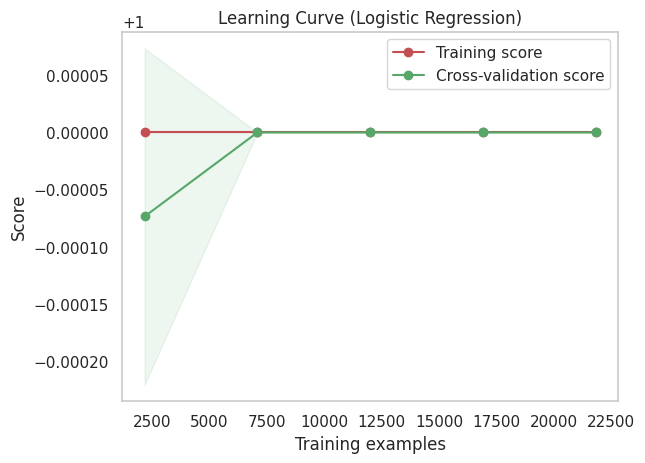

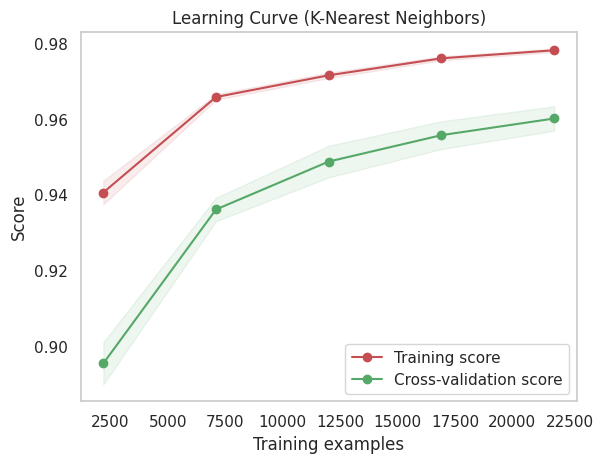

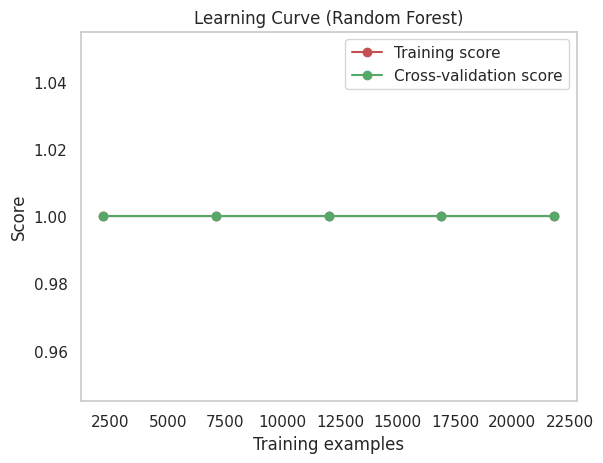

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for each classifier
for name, clf in classifiers.items():
    plot_learning_curve(clf, f"Learning Curve ({name})", X_train, y_train, cv=5, n_jobs=-1)

plt.show()


**Step 6.4: Best Model Complexity curve**

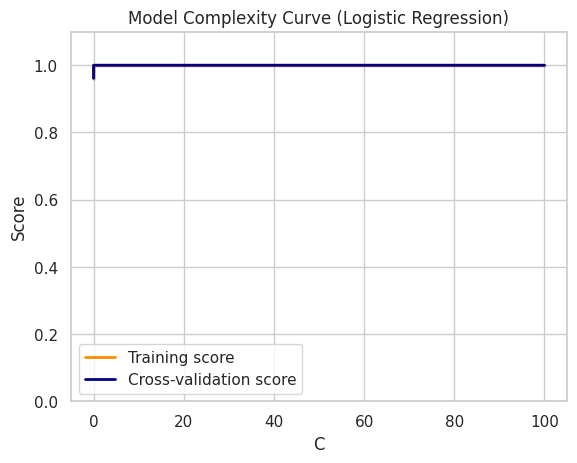

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Define a function to plot model complexity curves
def plot_model_complexity_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=None):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

# Plot model complexity curves for each classifier
for name, clf in classifiers.items():
    if name == 'KNeighbors Regressor':
        param_range = np.arange(1, 11)  # Example range of hyperparameter values
        plot_model_complexity_curve(clf, f"Model Complexity Curve ({name})", X_train, y_train, param_name='n_neighbors', param_range=param_range, cv=5, n_jobs=-1)
    elif name == 'Logistic Regression':
        param_range = [0.001, 0.01, 0.1, 1, 10, 100]  # Example range of hyperparameter values for Logistic Regression
        plot_model_complexity_curve(clf, f"Model Complexity Curve ({name})", X_train, y_train, param_name='C', param_range=param_range, cv=5, n_jobs=-1)
    elif name == 'RandomForest Regressor':
        param_range = [10, 50, 100, 200]  # Example range of hyperparameter values for RandomForest Regressor
        plot_model_complexity_curve(clf, f"Model Complexity Curve ({name})", X_train, y_train, param_name='n_estimators', param_range=param_range, cv=5, n_jobs=-1)

plt.show()


**Step 6.5: Best Method declaration**

In [ ]:
# Test set accuracies obtained from the grid search results
logistic_regression_accuracy = 1.0
knn_accuracy = 0.9615835777126099
random_forest_accuracy = 1.0

# Determine the best method based on test set accuracy
best_accuracy = max(logistic_regression_accuracy, knn_accuracy, random_forest_accuracy)

if best_accuracy == logistic_regression_accuracy:
    best_method = 'Logistic Regression'
elif best_accuracy == knn_accuracy:
    best_method = 'K-Nearest Neighbors'
elif best_accuracy == random_forest_accuracy:
    best_method = 'Random Forest'

print(f"The best method is: {best_method} with test set accuracy: {best_accuracy}")


The best method is: Logistic Regression with test set accuracy: 1.0


**Step 6.6: Classification Report**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the logistic regression model
best_model = LogisticRegression()

# Train your model
best_model.fit(X_train, y_train)

# Make predictions using the trained model
predictions = best_model.predict(X_test)

# Now you can evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate model performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1288
           1       1.00      1.00      1.00       157
           2       1.00      1.00      1.00      1619
           3       1.00      1.00      1.00      3756

    accuracy                           1.00      6820
   macro avg       1.00      1.00      1.00      6820
weighted avg       1.00      1.00      1.00      6820

Confusion Matrix:
[[1288    0    0    0]
 [   0  157    0    0]
 [   0    0 1619    0]
 [   0    0    0 3756]]



**Reference:**

1. ASHRAE - Great Energy Predictor III. (n.d.). Kaggle.com. https://www.kaggle.com/competitions/ashrae-energy-prediction/data

2.  ‌OpenAI. (2023). ChatGPT (Mar 14 version) [Large language model]

